Compatible with batchflow @346efe0

##  Implementation of FreezeOut method with ResNet on TensorFlow and BatchFlow
* [FreezeOut](https://arxiv.org/abs/1706.04983)
* [ResNet](https://arxiv.org/abs/1512.03385)

In this notebook, we research how FreezeOut method works with a small version of ResNet. The main idea of FreezeOut is very simple. The early blocks of a deep neural net have the fewest parameters, but take up the most computation.
For this reason, let's get layers freezing one-by-one and excluding them from the backward pass.

Every block (In original paper - every layer) has its own learning rate and turn off after a certain number of iterations. Blocks are excluded from the beginning to the end of the net.
For each block learning rate given as:

$$\alpha_{i}(t) = 0.5 * \alpha_{i}(0)*\left(1 + \cos\left(\frac{\pi*t}{t_i}\right)\right)$$

where:

* i - Number of layer.
* $\alpha_{i}(t)$ - Learning rate of i-th layer on interation t.
* $\alpha_i(0)$ - The initial learning rate of the layer. If you use scaled method, then $\alpha_i(0) = \frac{\alpha}{t_i}$ else, $\alpha$. $\alpha$ - is the base learning rate.
* $t$ - The number of the current iteration. 
* $t_i$ - The number of last iteration. After this iteration layer learning rate will be zero.

For an experiment, after the last layer will be disabled, we set learning rate for all layers = $1e-2$ and continue learning.

The paper suggest two ways of choosing the last iteration to disable layer:
* __Linear__ - choose the total number of iterations (t) and percentage, after which layer will be disabled. ${t_i}$ - all remaining layers will linearly space between t and ${t_0}$.
* __Cube__ - All same, but a percentage will space id cube dependencies.

In [1]:
import os
import sys

import blosc
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqn
from collections import OrderedDict
%matplotlib inline

sys.path.append('../../..')
from batch import ResBatch, ax_draw
from batchflow import Dataset, DatasetIndex

sys.path.append('../../utils')
import utils

We will train the model with the following parameters

In [2]:
optimal_params = {
    'iteration': [300] * 4,
    'learning_rate': [0.04, 0.06, 10, 14],
    'degree': [3, 1, 3, 1],
    'scaled': [False] * 2 + [True] * 2
}
optimal_params = OrderedDict(sorted(optimal_params.items(), key=lambda x: x[0]))

### About parameters:
* Iteration - Number of the last iteration for the model with FreezeOut, after this iteration, learning rates in all layers will be zero.
* learning rate - Initial learning rate for all layers. In the scaled method, it will be divided by a number of the last iteration for this layer.
* degree - __Linear__ or __Cube__, or __Square__ dependency for disable layers.
* scaled - __scaled__(True) of __unscaled__(False) method of disable layers.
 
The pictures below show how the learning rate will change.

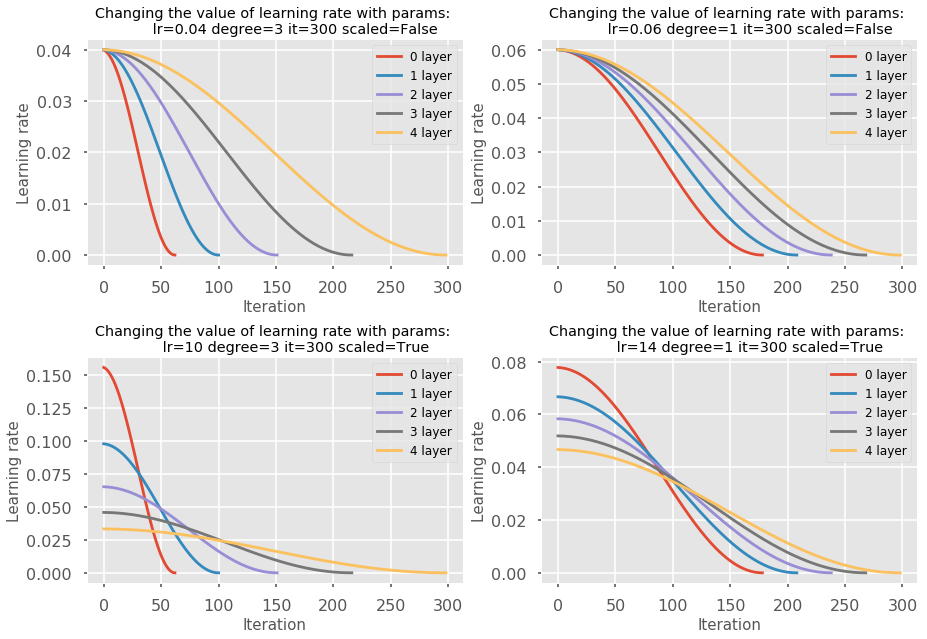

In [3]:
plt.style.use('seaborn-poster')
plt.style.use('ggplot')


iteration = 300
_, axarr = plt.subplots(2, 2)
axarr=axarr.reshape(-1)

for params in range(4):
    graph = []
    for i in range(1, 6):
        gefault_learning = optimal_params['learning_rate'][params]
        last = int(iteration*(i/10  + 0.5) ** optimal_params['degree'][params])
        if optimal_params['scaled'][params] == True:
            graph.append([0.5 * gefault_learning/last * (1 + np.cos(np.pi * i / last)) for i in range(2, last+1)])
        else:
            graph.append([0.5 * gefault_learning * (1 + np.cos(np.pi * i / last)) for i in range(2, last+1)])
   

    for i in range(len(graph)):
        axarr[params].set_title('Changing the value of learning rate with params: \n \
        lr={} degree={} it={} scaled={}'.format(gefault_learning, optimal_params['degree'][params], \
                                                             300, optimal_params['scaled'][params] ))
        axarr[params].plot(graph[i], label='{} layer'.format(i)) 
        axarr[params].set_xlabel('Iteration', fontsize=15)
        axarr[params].set_ylabel('Learning rate', fontsize=15)
    axarr[params].legend(fontsize=12)
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

We'll compare ResNet model with FreezeOut vs classic ResNet model.

First we load MNIST data

In [4]:
src = './../MNIST_data'
with open(os.path.join(src, 'mnist_pics.blk'), 'rb') as file:
    images = blosc.unpack_array(file.read()).reshape(-1, 28, 28)
with open(os.path.join(src, 'mnist_labels.blk'), 'rb') as file:
    labels = blosc.unpack_array(file.read())

In [5]:
global_freeze_loss = []
pipelines = []

Then create dataset and pipeline

In [6]:
res_loss=[]
ix = DatasetIndex(range(50000))
sess = tf.Session()
sess.run(tf.global_variables_initializer())
test_dset = Dataset(ix, ResBatch)
test_pipeline = (test_dset.p
                 .train_res(res_loss, images[:50000], labels[:50000]))
for i in tqn(range(500)):
    test_pipeline.next_batch(300,n_epochs=None, shuffle=2)

Widget Javascript not detected.  It may not be installed or enabled properly.


The __config__ allows to easily change the configuration of the model

In [7]:
params_list = pd.DataFrame(optimal_params).values
for params in tqn(params_list):
    freeze_loss = []

    config = {
        'freeznet':{'iteration': params[1],
                    'degree': params[0],
                    'learning_rate': params[2],
                    'scaled': params[3]}
    }
    dataset = Dataset(ix, batch_class=ResBatch)
    train_pipeline = (dataset
                      .pipeline(config=config)
                      .train_freez(freeze_loss, images[:50000], labels[:50000]))

    for i in tqn(range(1, 501)):
        train_pipeline.next_batch(300, n_epochs=None, shuffle=2)

    global_freeze_loss.append(freeze_loss)

Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Plots below show the losses of the models with different learning rate parameters

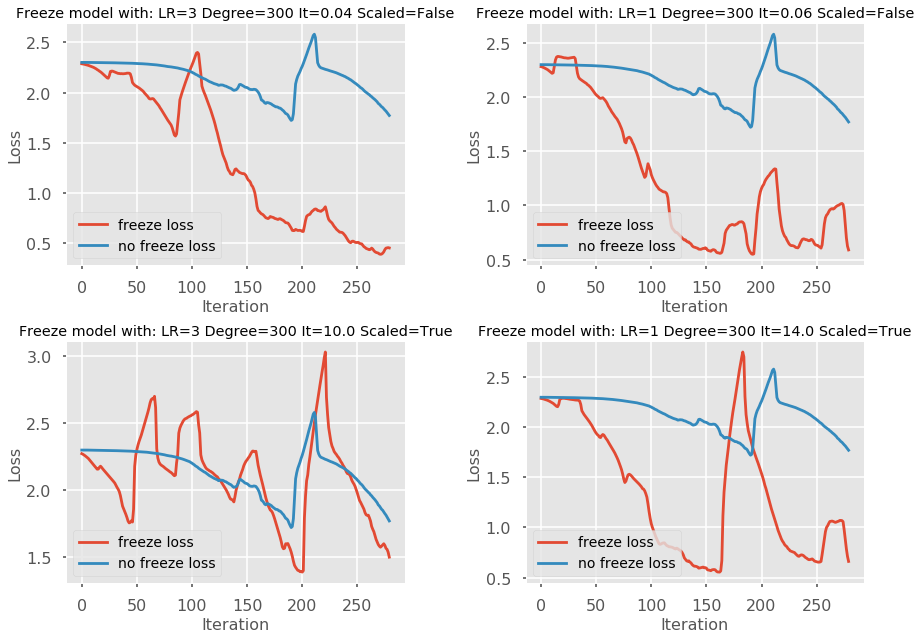

In [11]:
_, ax = plt.subplots(2,2)
ax = ax.reshape(-1)
for i in range(4):
    utils.ax_draw(global_freeze_loss[i][:300], res_loss[:300], params_list[i], ax[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

You can see models that use scaled method are more unstable.

The spikes in plots can be explained by large momentum. It is easy to see, what loss of the model with freezeout decrease faster than loss of the classic model.

If we continue to train the models, you can see an effect of the new learning rate(1e-2 is the same for all layers) on loss value.

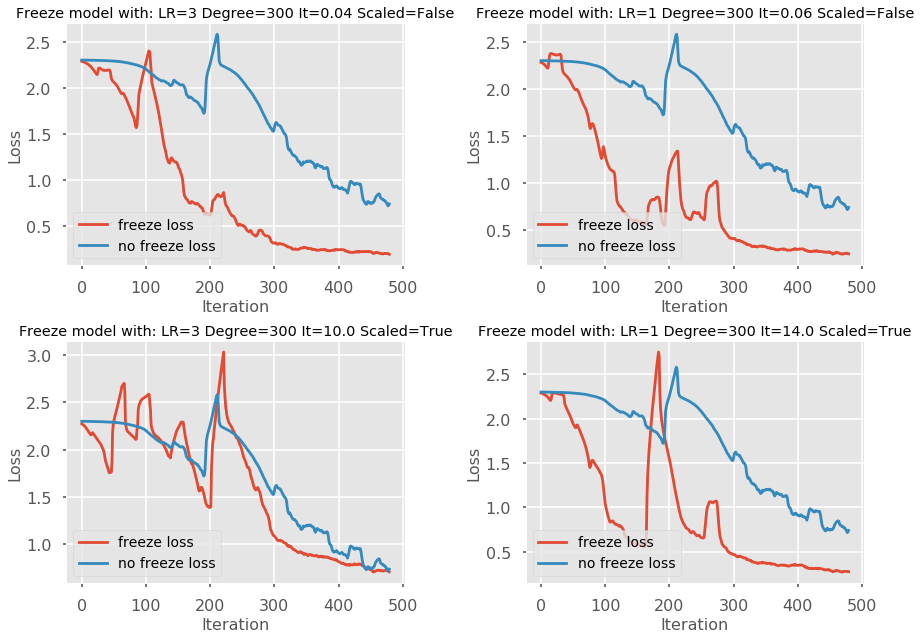

In [12]:
_, ax = plt.subplots(2,2)
ax = ax.reshape(-1)
for i in range(4):
    utils.ax_draw(global_freeze_loss[i], res_loss, params_list[i], ax[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

You can see that model with FreezeOut loss reaches the plateau faster than the classic model.

### Conclusion:
* FreezeOut might be useful in networks with skip-connection layers. The method decreases the numbers of iteration until convergence, but each iteration takes 3-4 times longer to complite compared to the classic model.
* We did not achieve good results with scaled learning rate because the later layers had to low learning rate and  could not train.
* On small number of iterations linear methods work better than cubic.

If you still have not completed our tutorial, you can fix it right [now](./../../tutorial/00_description.ipynb)!

Read and apply another experiments:
* next [experiment](./../augmentation/augmentation.ipynb)
* previous [experiment](./../squeeze_and_excitation/squeeze_and_excitation.ipynb)
* return to the [table of contents](./../experiments_description.ipynb).


#### Note:
Since the convergence of the model is very dependent on the initialization, you may need several re-initialization of the weights, in order to reproduce the results.